# Read in the data

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [91]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [92]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [93]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [94]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [95]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [96]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [97]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [98]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# Plotting survey correlations

In [99]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [100]:
survey_correlations = correlations[survey_fields]

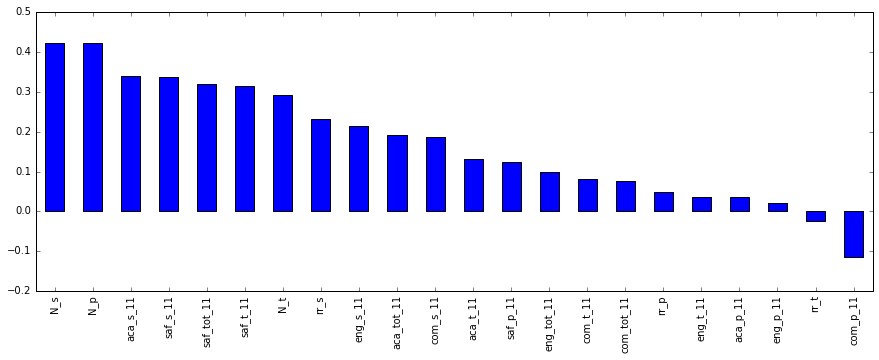

In [101]:
survey_correlations.sort_values(ascending=False,inplace=True)
survey_correlations.plot.bar(figsize=(15,5))
plt.show()

##### Survey parameters with high correlation to SAT scores:
1. A reasonably strong positive correlation exists between the number of student and parent responses and SAT scores. This may be a proxy for how invested these students and families are in education. It could also, on the other hand, be further manifestation of the fact that english language learners tend to score lower on the SAT. This needs to be investigated further.

      1b. Note that RESPONSE RATES are not as strongly correlated as the total responses which may indicate that the above identified fly in the ointment is causing these correlations rather than a direct link between number of respondants and scores.
2. It is not surprising that survey responses that indicate that schools are a safe and academically challenging place are positively correlated with SAT scores. Note that student responses to this end are sightly better correlated to SAT scores than the responses of teachers. Parent responses are even more weakly correlated. Perhaps because parents are not as closely tied to the school as students and teachers.
3. STUDENT perception of high academic expectations is far better correlated to SAT scores than the perceptions of parents and teachers. Perhaps adults don't have a good grasp on the challenges of high school academics.
4. STUDENT engagement follows a similar trend to that of (3) above.
5. There is a WEAK negative correlation between parent communication scores and SAT tests. Would need to investigate what is meant by "communication" in the context of this survey.


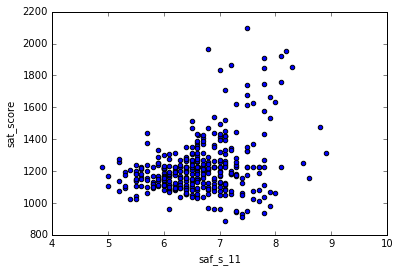

In [102]:
combined.plot.scatter('saf_s_11', 'sat_score')
plt.show()

Schools with low safety scores cluster around lower SAT scores, while schools with higher safety scores often have significantly higher average sat scores.

In [103]:
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)
print(districts.head())

  school_dist  SAT Critical Reading Avg. Score  SAT Math Avg. Score  \
0          01                       441.833333           473.333333   
1          02                       426.619092           444.186256   
2          03                       428.529851           437.997512   
3          04                       402.142857           416.285714   
4          05                       427.159915           438.236674   

   SAT Writing Avg. Score    sat_score  AP Test Takers   Total Exams Taken  \
0              439.333333  1354.500000       116.681090         173.019231   
1              424.832836  1295.638184       128.908454         201.516827   
2              426.915672  1293.443035       156.183494         244.522436   
3              405.714286  1224.142857       129.016484         183.879121   
4              419.666098  1285.062687        85.722527         115.725275   

   Number of Exams with scores 3 4 or 5  Total Cohort  CSD    ...      \
0                            13

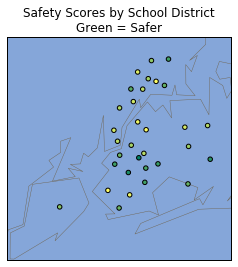

In [104]:
from mpl_toolkits.basemap import Basemap
m = Basemap(
    projection='merc', 
    llcrnrlat=40.496044, 
    urcrnrlat=40.915256, 
    llcrnrlon=-74.255735, 
    urcrnrlon=-73.700272,
    resolution='i'
)

m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

longitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longitudes, latitudes, latlon=True, zorder=2, s=20, c=districts['saf_s_11'], cmap='summer')
plt.title('Safety Scores by School District\nGreen = Safer')
plt.show()

The most dangerous schools are in NW Queens, S Brooklyn, and the Bronx. Manhattan and Statten schools are midrange. Safest schools are in central/N Brooklyn, E Queens/JFK area.

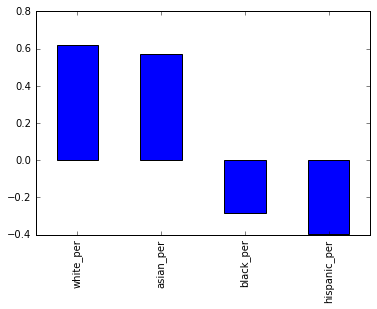

In [105]:
races = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
scores_by_race = correlations[races]
scores_by_race.plot.bar()
plt.show()

White and asian percentages strongly correlate to higher SAT scores, while black and hispanic percentages correlate moderately to strongly negatively to higher SAT scores. This is unfortunately not a surprise.

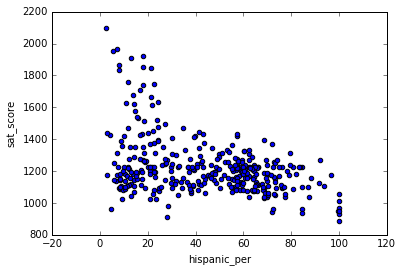

In [106]:
combined.plot.scatter('hispanic_per','sat_score')
plt.show()

This correlation appears to be weakest at hispanic percentages below 10-15%

In [107]:
hispanic_greater_95 = combined[combined['hispanic_per']>95]
print(hispanic_greater_95['ell_percent'])

44     72.6
82     19.6
89     89.6
125    86.6
141    79.9
176    92.9
253    94.6
286    91.3
Name: ell_percent, dtype: float64


The majority of the above subset of schools have >70% of english language learners, which we know is strongly correlated with low SAT scores. This is a subset of mainly international schools.

In [108]:
print(hispanic_greater_95)

        DBN                                        SCHOOL NAME  \
44   02M542                      MANHATTAN BRIDGES HIGH SCHOOL   
82   06M348   WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL   
89   06M552  GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...   
125  09X365                ACADEMY FOR LANGUAGE AND TECHNOLOGY   
141  10X342              INTERNATIONAL SCHOOL FOR LIBERAL ARTS   
176  12X388   PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE   
253  19K583                          MULTICULTURAL HIGH SCHOOL   
286  24Q296             PAN AMERICAN INTERNATIONAL HIGH SCHOOL   

    Num of SAT Test Takers  SAT Critical Reading Avg. Score  \
44                      66                            336.0   
82                      70                            380.0   
89                      56                            339.0   
125                     54                            315.0   
141                     49                            300.0   
176                     30 

In [109]:
hispanic_less_10 = combined[combined['hispanic_per']<10]
hispanic_less_10_SAT_greater_1800 = hispanic_less_10[hispanic_less_10['sat_score']>1800]
hispanic_less_10_SAT_greater_1800

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
37,02M475,STUYVESANT HIGH SCHOOL,832,679.0,735.0,682.0,2096.0,STUYVESANT HS,1510.0,2819.0,...,0,0,0,0,0,0,"345 Chambers Street\nNew York, NY 10282\n(40.7...",40.717746,-74.014049,02
151,10X445,BRONX HIGH SCHOOL OF SCIENCE,731,632.0,688.0,649.0,1969.0,BRONX HS OF SCIENCE,1190.0,2435.0,...,0,0,0,0,0,0,"75 West 205 Street\nBronx, NY 10468\n(40.87705...",40.877056,-73.889780,10
187,13K430,BROOKLYN TECHNICAL HIGH SCHOOL,1277,587.0,659.0,587.0,1833.0,BROOKLYN TECHNICAL HS,2117.0,3692.0,...,0,0,0,0,0,0,"29 Ft Greene Place\nBrooklyn, NY 11217\n(40.68...",40.688107,-73.976745,13
327,28Q687,QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...,121,612.0,660.0,596.0,1868.0,Queens HS for Science York Colllege,215.0,338.0,...,0,0,0,0,0,0,"94-50 159 Street\nJamaica, NY 11433\n(40.70099...",40.700999,-73.798154,28
356,31R605,STATEN ISLAND TECHNICAL HIGH SCHOOL,227,635.0,682.0,636.0,1953.0,STATEN ISLAND TECHNICAL HS,528.0,905.0,...,0,0,0,0,0,0,"485 Clawson Street\nStaten Island, NY 10306\n(...",40.567913,-74.115362,31


The schools above are all highly acclaimed and well regarded technical high schools.

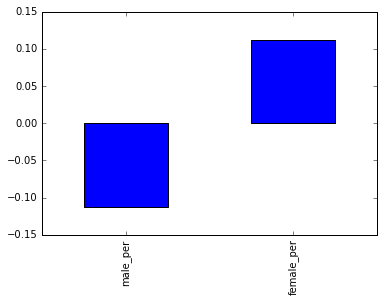

In [110]:
genders = ['male_per', 'female_per']
gender_correlations = correlations[genders]
gender_correlations.plot.bar()
plt.show()

It is not surprising that higher female percentages correlate with better SAT scores. Due to the fact that gender is binary (at least in this dataset), the male correlation is inversely proportinal.

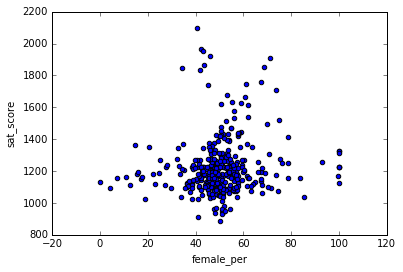

In [111]:
combined.plot.scatter('female_per','sat_score')

Most schools cluster around 50-50 gender ratio, there doesn't appear to be a very strong linear correlation.

In [112]:
temp = combined[combined['female_per']>60]
female_greater_60_sat_greater_1700 = temp[temp['sat_score']>1700]
female_greater_60_sat_greater_1700

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
5,01M696,BARD HIGH SCHOOL EARLY COLLEGE,130,624.0,604.0,628.0,1856.0,0,129.028846,197.038462,...,0,0,0,0,0,0,"525 East Houston Street\nNew York, NY 10002\n(...",40.718962,-73.976066,01
26,02M416,ELEANOR ROOSEVELT HIGH SCHOOL,127,572.0,594.0,592.0,1758.0,Eleanor Roosevelt High School,155.000000,235.000000,...,0,0,0,0,0,0,"411 East 76 Street\nNew York, NY 10021\n(40.77...",40.770116,-73.953379,02
60,03M479,BEACON HIGH SCHOOL,261,577.0,575.0,592.0,1744.0,BEACON SCHOOL,166.000000,197.000000,...,0,0,0,0,0,0,"227-243 West 61St Street\nNew York, NY 10023\n...",40.772158,-73.987797,03
61,03M485,FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...,531,566.0,564.0,577.0,1707.0,FIORELLO H.LAGUARDIA HS,691.000000,1236.000000,...,0,0,0,0,0,0,"100 Amsterdam Avenue\nNew York, NY 10023\n(40....",40.773671,-73.985269,03
302,25Q525,TOWNSEND HARRIS HIGH SCHOOL,278,621.0,651.0,638.0,1910.0,TOWNSEND HARRIS HS,613.000000,796.000000,...,0,0,0,0,0,0,"149-11 Melbourne Avenue\nFlushing, NY 11367\n(...",40.734408,-73.821417,25


The above are all competetive college prep schools

In [113]:
combined['ap_per'] = combined['AP Test Takers '] / combined['total_enrollment']

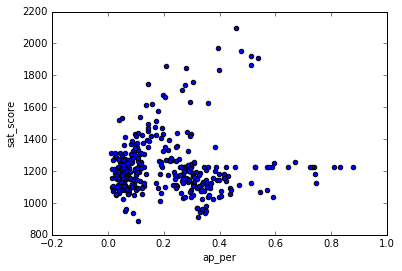

In [115]:
combined.plot.scatter('ap_per', 'sat_score')

Appears to be a positive correlation between AP Test Percentge and SAT score, but with the caveat that there is a cluster of relatively higher AP per and lower SAT scores that should be investigated.